In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import wandb
import spacy
import random
import logging
import pytextrank
from tqdm import tqdm
from torch.optim import Adam
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from datasets import load_dataset,concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification

In [2]:
# Summarize the input to how many tokens, default to 512 for BERT use.
# Since LongFormer could accept 4096 tokens, we could skip TextRank if LongFormer
seed_val = 42
ENABLE_TEXT_RANK = False
TEXT_RANK_LENGTH = 512
LEARNING_RATE = 2e-5
NUM_EPOCHS = 4

MODEL = ["T5base","roberta","Distilbert","FlanT5small","FlanT5base"] # Choose from "T5base", "roberta", "Distilbert", "FlanT5small"

NEW_BATCH_SIZE = 8 if MODEL in ["roberta", "Distilbert", "FlanT5small"] else 4 

#wandb.login(key='bf24a38a046a0448057459477a5d48fbc6eb2f6a')
#wandb.init()

In [3]:
# If there's a GPU available...
# If GPU not available, training will cost SEVERAL DAYS, not recommended running on CPU
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU insteadp(not recommended).')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [4]:
dataset = load_dataset("argilla/banking_sentiment_setfit")
test = concatenate_datasets([dataset['train'], dataset['test']])
test_text = test['text']
test_label = ['neutral' if i == 1 else 'negative' for i in test['label']]
test[:5]

Found cached dataset parquet (/home/fangkangmi/.cache/huggingface/datasets/argilla___parquet/argilla--banking_sentiment_setfit-4a60f83f113675bf/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

{'text': ['are you sending me my card?',
  "Two days ago I did a transfer to another account within the country.  It doesn't appear the transfer went through.  I have verified the account number several times.  Could you please check on this for me?",
  "Why didn't I receive the right amount of cash?",
  "Is there a reason why my virtual card won't work?",
  'Why is my balance the same after a transfer?'],
 'label': [1, 1, 0, 0, 1]}

In [5]:
# Set the seed value all over the place to make this reproducible.
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [6]:
model_options = {
    "T5base": "michelecafagna26/t5-base-finetuned-sst2-sentiment",
    "roberta":"cardiffnlp/twitter-roberta-base-sentiment-latest",
    "Distilbert": "distilbert-base-uncased-finetuned-sst-2-english",
    "FlanT5small": "cardiffnlp/flan-t5-small-tweet-sentiment",
    "FlanT5base": "cardiffnlp/flan-t5-base-tweet-sentiment"
}

In [7]:
def set_model_and_tokenizer(model):
    return AutoModelForSeq2SeqLM.from_pretrained(model_options.get(model)) if model in ["T5base", "FlanT5small", "FlanT5base"] \
           else AutoModelForSequenceClassification.from_pretrained(model_options.get(model))\
           ,AutoTokenizer.from_pretrained(model_options.get(model))

# Models

By now the test dataset, model and tokenizer has been loaded. The next step is to tokenize the dataset and evaluate their performance

In [9]:

def T5_get_sentiment(tensor):
    preds = model.generate(tensor)
    decoded_preds = tokenizer.batch_decode(sequences=preds, skip_special_tokens=True)
    return decoded_preds

if('T5base' in MODEL):
    model, tokenizer = set_model_and_tokenizer('T5base')
    
    #Add prompt
    T5_test_text = ["sentiment: " + item for item in test_text]
    #Tokenizer
    T5_tokenized_text = tokenizer(T5_test_text, max_length=128, padding=True, return_tensors="pt")['input_ids']
    
    #Create the prediction
    T5_predict = T5_get_sentiment(torch.tensor(T5_tokenized_text))
    T5_predict_digit = ['neutral' if i == 'p' else 'negative' for i in T5_predict]
    
    # Print the classification report
    # 1 means positive 0 means negative
    report = classification_report(test_label,T5_predict_digit)
    print(report)


/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ipykernel_31458/1883409789.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T5_predict = T5_get_sentiment(torch.tensor(T5_tokenized_text))
/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.38      0.94      0.54        51
     neutral       0.81      0.14      0.24        93

    accuracy                           0.42       144
   macro avg       0.59      0.54      0.39       144
weighted avg       0.66      0.42      0.34       144



In [26]:
class RoBERTa_Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

if('roberta' in MODEL):

    model, tokenizer = set_model_and_tokenizer('roberta')
    
    #Add prompt
    RoBERTa_test_text = [" " + item for item in test_text]
    
    #Tokenize, with max_length= 128 could increase the accuracy from 50 -> 53
    RoBERTa_tokenized_text = tokenizer(RoBERTa_test_text,max_length=128, padding=True, return_tensors="pt")
    
    #Dataset and Dataloader
    RoBERTa_dataset_test = RoBERTa_Dataset(RoBERTa_tokenized_text,test['label'])
    RoBERTa_dataloader = DataLoader(RoBERTa_dataset_test, batch_size=8, shuffle=True)

    # Iterate over the test dataset

    torch.cuda.empty_cache()
    model.eval()
    model.to('cuda')
    predictions = []
    true_labels = []

    for batch in RoBERTa_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}

        # Disable gradient calculation
        with torch.no_grad():
            # Perform inference
            outputs = model(**batch)

        predicted_values = outputs.logits

        predictions.extend(predicted_values)
        true_labels.extend(batch['labels'].tolist())
    # Convert logits to predictions
    # 1 and 2 means positive and 0 means negative
    predictions = [torch.argmax(item).item() for item in predictions]
    predictions = ['neutral' if (i == 1 or i == 2) else 'negative' for i in predictions]
    true_labels = ['neutral' if (i == 1 or i == 2) else 'negative' for i in true_labels]
    # Generate classification report
    report = classification_report(true_labels, predictions)
    print(report)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ip

              precision    recall  f1-score   support

    negative       0.67      0.73      0.70        51
     neutral       0.84      0.81      0.82        93

    accuracy                           0.78       144
   macro avg       0.76      0.77      0.76       144
weighted avg       0.78      0.78      0.78       144



In [13]:
dataset = load_dataset("argilla/banking_sentiment_setfit")
DistilBERT_train = dataset['train']
DistilBERT_test = dataset['test']

DistilBERT_train_text, DistilBERT_test_text = DistilBERT_train['text'], DistilBERT_test['text']

DistilBERT_train_label = ['neutral' if i == 1 else 'negative' for i in test['label']]
DistilBERT_test_label = ['neutral' if i == 1 else 'negative' for i in test['label']]


Found cached dataset parquet (/home/fangkangmi/.cache/huggingface/datasets/argilla___parquet/argilla--banking_sentiment_setfit-4a60f83f113675bf/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Starting epoch 0


Training:   0%|                                          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_32008/256424947.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|█████████████████████████████████| 14/14 [00:00<00:00, 16.52it/s]


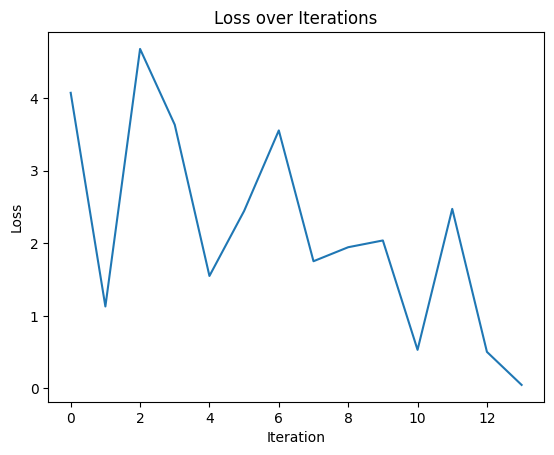

Starting epoch 1


Training: 100%|█████████████████████████████████| 14/14 [00:00<00:00, 16.78it/s]


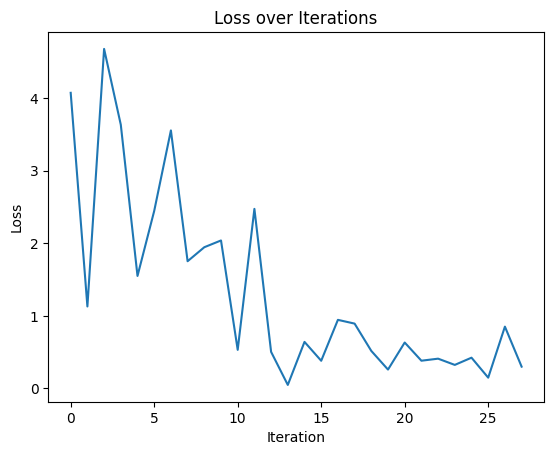

Starting epoch 2


Training: 100%|█████████████████████████████████| 14/14 [00:00<00:00, 16.32it/s]


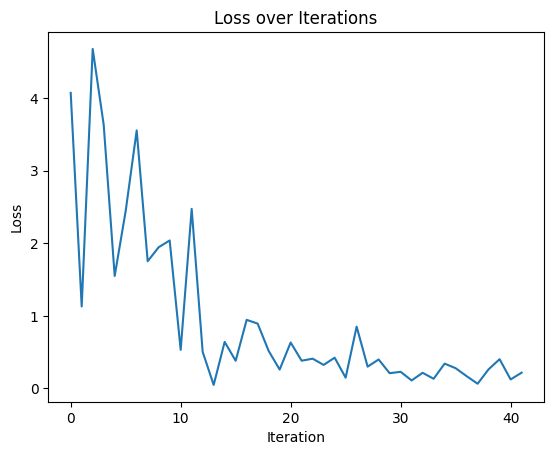

Starting epoch 3


Training: 100%|█████████████████████████████████| 14/14 [00:00<00:00, 17.20it/s]


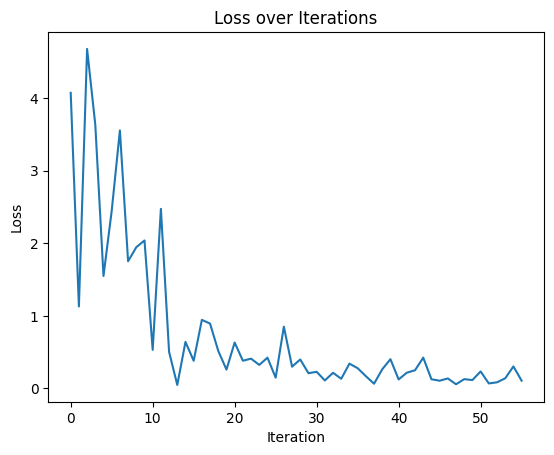

In [14]:
class Distilbert_Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

model, tokenizer = set_model_and_tokenizer('Distilbert')

#No prompt for this 
Distilbert_train_tokenized_text = tokenizer(DistilBERT_train_text,max_length=128, padding=True,  return_tensors="pt")
Distilbert_test_tokenized_text = tokenizer(DistilBERT_test_text,max_length=128, padding=True,  return_tensors="pt")

#Dataset and Dataloader
Distilbert_dataset_train = Distilbert_Dataset(Distilbert_train_tokenized_text,DistilBERT_train['label'])
Distilbert_dataset_test = Distilbert_Dataset(Distilbert_test_tokenized_text,DistilBERT_test['label'])
Distilbert_dataloader_train = DataLoader(Distilbert_dataset_train, batch_size=8, shuffle=True)
Distilbert_dataloader_test = DataLoader(Distilbert_dataset_test, batch_size=8, shuffle=True)


# Initialize the optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Move the model to the GPU
model.train()
model.to('cuda')

# Initialize a list to store the loss values
losses = []
start_epoch = 0

# Training 
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"Starting epoch {epoch}")
    for batch in tqdm(Distilbert_dataloader, desc="Training"):
        batch = {k: v.to('cuda') for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Optimize the model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Append the loss value to the list
        losses.append(loss.item())  

    # Plot the loss values after each epoch
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over Iterations')
    plt.show()


In [15]:
# Iterate over the test dataset

torch.cuda.empty_cache()
model.eval()
model.to('cuda')
predictions = []
true_labels = []

for batch in Distilbert_dataloader_test:
    batch = {k: v.to('cuda') for k, v in batch.items()}

    
    # Disable gradient calculation
    with torch.no_grad():
        # Perform inference
        outputs = model(**batch)

    predicted_values = outputs.logits
    predictions.extend(predicted_values)
    true_labels.extend(batch['labels'].tolist())
# Convert logits to predictions,  
# 1 means positive and 0 means negative
predictions = [torch.argmax(item).item() for item in predictions]
predictions = ['neutral' if i == 1 else 'negative' for i in predictions]
true_labels = ['neutral' if i == 1 else 'negative' for i in true_labels]
# Generate classification report
report = classification_report(true_labels, predictions)
print(report)
    

              precision    recall  f1-score   support

    negative       0.53      0.67      0.59        12
     neutral       0.81      0.71      0.76        24

    accuracy                           0.69        36
   macro avg       0.67      0.69      0.67        36
weighted avg       0.72      0.69      0.70        36



/tmp/ipykernel_32008/702547249.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [16]:
# Iterate over the test dataset
model, tokenizer = set_model_and_tokenizer('Distilbert')
    

torch.cuda.empty_cache()
model.eval()
model.to('cuda')
predictions = []
true_labels = []

for batch in Distilbert_dataloader_test:
    batch = {k: v.to('cuda') for k, v in batch.items()}

    
    # Disable gradient calculation
    with torch.no_grad():
        # Perform inference
        outputs = model(**batch)

    predicted_values = outputs.logits
    predictions.extend(predicted_values)
    true_labels.extend(batch['labels'].tolist())
# Convert logits to predictions,  
# 1 means positive and 0 means negative
predictions = [torch.argmax(item).item() for item in predictions]
predictions = ['neutral' if i == 1 else 'negative' for i in predictions]
true_labels = ['neutral' if i == 1 else 'negative' for i in true_labels]
# Generate classification report
report = classification_report(true_labels, predictions)
print(report)
    

              precision    recall  f1-score   support

    negative       0.35      1.00      0.52        12
     neutral       1.00      0.08      0.15        24

    accuracy                           0.39        36
   macro avg       0.68      0.54      0.34        36
weighted avg       0.78      0.39      0.28        36



/tmp/ipykernel_32008/702547249.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [17]:
class Distilbert_Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

if('Distilbert' in MODEL):
    model, tokenizer = set_model_and_tokenizer('Distilbert')
    
    #No prompt for this 
    Distilbert_tokenized_text = tokenizer(RoBERTa_test_text,max_length=128, padding=True,  return_tensors="pt")
    
    #Dataset and Dataloader
    Distilbert_dataset_test = Distilbert_Dataset(Distilbert_tokenized_text,test['label'])
    Distilbert_dataloader = DataLoader(Distilbert_dataset_test, batch_size=8, shuffle=True)

    # Iterate over the test dataset

    torch.cuda.empty_cache()
    model.eval()
    model.to('cuda')
    predictions = []
    true_labels = []

    for batch in Distilbert_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}

        # Disable gradient calculation
        with torch.no_grad():
            # Perform inference
            outputs = model(**batch)

        predicted_values = outputs.logits
        predictions.extend(predicted_values)
        true_labels.extend(batch['labels'].tolist())
    # Convert logits to predictions,  
    # 1 means positive and 0 means negative
    predictions = [torch.argmax(item).item() for item in predictions]
    predictions = ['neutral' if i == 1 else 'negative' for i in predictions]
    true_labels = ['neutral' if i == 1 else 'negative' for i in true_labels]
    # Generate classification report
    report = classification_report(true_labels, predictions)
    print(report)

/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ipykernel_31458/2342649218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


[tensor([ 2.6344, -2.1943], device='cuda:0'), tensor([ 4.2249, -3.4419], device='cuda:0'), tensor([ 4.1324, -3.3406], device='cuda:0'), tensor([ 3.8986, -3.2051], device='cuda:0'), tensor([ 4.2655, -3.4120], device='cuda:0')]
              precision    recall  f1-score   support

    negative       0.35      0.94      0.51        51
     neutral       0.57      0.04      0.08        93

    accuracy                           0.36       144
   macro avg       0.46      0.49      0.30       144
weighted avg       0.49      0.36      0.23       144



In [21]:
def Flan_T5_get_sentiment(tensor):
    preds = model.generate(tensor)
    decoded_preds = tokenizer.batch_decode(sequences=preds, skip_special_tokens=True)
    return decoded_preds

if('FlanT5small' in MODEL):
    model, tokenizer = set_model_and_tokenizer('FlanT5small')
    
    #Add prompt
    Flan_T5_small_test_text = ["Bank sentiment: "+ item for item in test_text]
    #Tokenizer
    Flan_T5_small_tokenized_test = tokenizer(Flan_T5_small_test_text, \
                                             max_length=128, padding=True, return_tensors="pt")['input_ids']
    
    
    Flan_T5_small_predict = Flan_T5_get_sentiment(torch.tensor(Flan_T5_small_tokenized_test))
    Flan_T5_small_predict_digit = ['neutral' if ('neutral' in i or 'positive' in i) else 'negative' for i in Flan_T5_small_predict]
    # Print the classification report
    # 1 means positive 0 means negative
    report = classification_report(test_label,Flan_T5_small_predict_digit)
    print(report)


/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ipykernel_31458/2028437801.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Flan_T5_small_predict = Flan_T5_get_sentiment(torch.tensor(Flan_T5_small_tokenized_test))
/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.51      0.82      0.63        51
     neutral       0.85      0.56      0.68        93

    accuracy                           0.65       144
   macro avg       0.68      0.69      0.65       144
weighted avg       0.73      0.65      0.66       144



In [19]:
Flan_T5_small_predict

['negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative',
 'negative or neutral',
 'positive',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative',
 'negative or neutral',
 'negative or neutral',
 'positive',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'positive',
 'negative or neutral',
 'negative or neutral',
 'negative or neutral',
 'positive',
 'negative or neutral',
 'positive

In [14]:
def Flan_T5_get_sentiment(tensor):
    preds = model.generate(tensor)
    decoded_preds = tokenizer.batch_decode(sequences=preds, skip_special_tokens=True)
    return decoded_preds

if('FlanT5base' in MODEL):
    model, tokenizer = set_model_and_tokenizer('FlanT5base')
    
    #Add prompt
    Flan_T5_base_test_text = ["Please classify the sentiment of follwing text as 'neutral', 'positive' or 'negative': "\
                              + item for item in test_text]
    #Tokenizer
    Flan_T5_base_tokenized_test = tokenizer(Flan_T5_base_test_text, \
                                             max_length=128, padding=True, return_tensors="pt")['input_ids']
    
    
    Flan_T5_base_predict = Flan_T5_get_sentiment(torch.tensor(Flan_T5_base_tokenized_test))
    Flan_T5_base_predict_digit = ['negative' if i == 'negative' else 'neutral' for i in Flan_T5_base_predict]
    # Print the classification report
    # 1 means positive 0 means negative
    report = classification_report(test_label,Flan_T5_base_predict_digit)
    print(report)


/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/tmp/ipykernel_31458/587979243.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Flan_T5_base_predict = Flan_T5_get_sentiment(torch.tensor(Flan_T5_base_tokenized_test))
/home/fangkangmi/miniconda3/envs/textsum/lib/python3.9/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.39      0.98      0.56        51
     neutral       0.94      0.17      0.29        93

    accuracy                           0.46       144
   macro avg       0.67      0.58      0.43       144
weighted avg       0.75      0.46      0.39       144



In [15]:
Flan_T5_base_predict

['positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',


In [16]:
#Below are using pipeline that provided by 
#https://huggingface.co/cardiffnlp/flan-t5-base-tweet-sentiment?text=context%3A+If+I+make+a+game+as+a+%23windows10+Universal+App.+Will+%23xboxone+owners+be+able+to+download+and+play+it+in+November%3F+%40majornelson+%40Microsoft%2C+target%3A+%40microsoft
from transformers import pipeline

pipe = pipeline('text2text-generation', model="cardiffnlp/flan-t5-base-tweet-sentiment")

Flan_T5_base_predict_digit_pipeline = ['negative' if i == 'negative' else 'neutral' for i in  Flan_T5_base_output]
# Print the classification report
# 1 means positive 0 means negative
report = classification_report(test_label,Flan_T5_base_predict_digit)
print(report)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_31458/1793374809.py:7 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_31458/1793374809.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'Flan_T5_base_output' is not defined